In [2]:
# datapreprocessor.py

import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple, Any
import logging
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, SMOTEN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import joblib  # For saving/loading transformers
from inspect import signature  # For parameter validation in SMOTE

class DataPreprocessor:
    def __init__(
        self,
        model_type: str,
        y_variable: List[str],
        ordinal_categoricals: List[str],
        nominal_categoricals: List[str],
        numericals: List[str],
        mode: str,  # 'train', 'predict', 'clustering'
        options: Optional[Dict] = None,
        debug: bool = False,
        normalize_debug: bool = False,
        normalize_graphs_output: bool = False,
        graphs_output_dir: str = './plots',
        transformers_dir: str = './transformers'
    ):
        """
        Initialize the DataPreprocessor with model type and feature lists.

        Args:
            model_type (str): Type of the machine learning model (e.g., 'Logistic Regression').
            y_variable (List[str]): List of target variable(s).
            ordinal_categoricals (List[str]): List of ordinal categorical features.
            nominal_categoricals (List[str]): List of nominal categorical features.
            numericals (List[str]): List of numerical features.
            mode (str): Operational mode ('train', 'predict', 'clustering').
            options (Optional[Dict]): User-defined options for preprocessing steps.
            debug (bool): General debug flag to control overall verbosity.
            normalize_debug (bool): Flag to display normalization plots.
            normalize_graphs_output (bool): Flag to save normalization plots.
            graphs_output_dir (str): Directory to save plots.
            transformers_dir (str): Directory to save/load transformers.
        """
        self.model_type = model_type
        self.y_variable = y_variable
        self.ordinal_categoricals = ordinal_categoricals
        self.nominal_categoricals = nominal_categoricals
        self.numericals = numericals
        self.mode = mode.lower()
        if self.mode not in ['train', 'predict', 'clustering']:
            raise ValueError("Mode must be one of 'train', 'predict', or 'clustering'.")
        self.options = options or {}
        self.debug = debug
        self.normalize_debug = normalize_debug
        self.normalize_graphs_output = normalize_graphs_output
        self.graphs_output_dir = graphs_output_dir
        self.transformers_dir = transformers_dir

        # Initialize categorical_indices to prevent AttributeError
        self.categorical_indices = []

        # Define model categories for accurate processing
        self.model_category = self.map_model_type_to_category()

        if self.model_category == 'unknown':
            self.logger = logging.getLogger(self.__class__.__name__)
            self.logger.error(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
            raise ValueError(f"Model category for '{self.model_type}' is unknown. Check your configuration.")

        # Initialize y_variable based on mode and model category
        if self.mode in ['train', 'predict'] and self.model_category in ['classification', 'regression']:
            if not self.y_variable:
                if self.mode == 'train':
                    raise ValueError("Target variable 'y_variable' must be specified for supervised models in train mode.")
                # In predict mode, y_variable might not be present
        else:
            # For 'clustering' mode or unsupervised prediction
            self.y_variable = []

        # Initialize other variables
        self.scaler = None
        self.transformer = None
        self.ordinal_encoder = None
        self.nominal_encoder = None
        self.preprocessor = None
        self.smote = None
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        self.preprocessing_steps = []
        self.normality_results = {}
        self.features_to_transform = []
        self.nominal_encoded_feature_names = []
        self.final_feature_order = []

        # Initialize placeholders for clustering-specific transformers
        self.cluster_transformers = {}
        self.cluster_model = None
        self.cluster_labels = None
        self.silhouette_score = None

        # Define default thresholds for SMOTE recommendations
        self.imbalance_threshold = self.options.get('smote_recommendation', {}).get('imbalance_threshold', 0.1)
        self.noise_threshold = self.options.get('smote_recommendation', {}).get('noise_threshold', 0.1)
        self.overlap_threshold = self.options.get('smote_recommendation', {}).get('overlap_threshold', 0.1)
        self.boundary_threshold = self.options.get('smote_recommendation', {}).get('boundary_threshold', 0.1)

        self.pipeline = None  # Initialize pipeline

        # Initialize logging
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)
            
        # Initialize feature_reasons with 'all_numericals' for clustering
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        if self.model_category == 'clustering':
            self.feature_reasons['all_numericals'] = ''

    def get_debug_flag(self, flag_name: str) -> bool:
        """
        Retrieve the value of a specific debug flag from the options.
        Args:
            flag_name (str): The name of the debug flag.
        Returns:
            bool: The value of the debug flag.
        """
        return self.options.get(flag_name, False)

    def _log(self, message: str, step: str, level: str = 'info'):
        """
        Internal method to log messages based on the step-specific debug flags.
        
        Args:
            message (str): The message to log.
            step (str): The preprocessing step name.
            level (str): The logging level ('info', 'debug', etc.).
        """
        debug_flag = self.get_debug_flag(f'debug_{step}')
        if debug_flag:
            if level == 'debug':
                self.logger.debug(message)
            elif level == 'info':
                self.logger.info(message)
            elif level == 'warning':
                self.logger.warning(message)
            elif level == 'error':
                self.logger.error(message)

    def map_model_type_to_category(self) -> str:
        """
        Map the model_type string to a predefined category based on keywords.

        Returns:
            str: The model category ('classification', 'regression', 'clustering', etc.).
        """
        classification_keywords = ['classifier', 'classification', 'logistic', 'svm', 'support vector machine', 'knn', 'neural network']
        regression_keywords = ['regressor', 'regression', 'linear', 'knn', 'neural network']  # Removed 'svm'
        clustering_keywords = ['k-means', 'clustering', 'dbscan', 'kmodes', 'kprototypes']

        model_type_lower = self.model_type.lower()

        for keyword in classification_keywords:
            if keyword in model_type_lower:
                return 'classification'

        for keyword in regression_keywords:
            if keyword in model_type_lower:
                return 'regression'

        for keyword in clustering_keywords:
            if keyword in model_type_lower:
                return 'clustering'

        return 'unknown'

    def filter_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        step_name = "filter_columns"
        self.logger.info(f"Step: {step_name}")

        # Combine all feature lists
        desired_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals

        # For 'train' and 'clustering' modes, handle y_variable appropriately
        if self.mode == 'train':
            # Ensure y_variable is present in the data but not included in features
            if not all(col in df.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in df.columns]
                self.logger.error(f"Target variable(s) {missing_y} not found in the input data.")
                raise ValueError(f"Target variable(s) {missing_y} not found in the input data.")
            # Exclude y_variable from features
            desired_features = [col for col in desired_features if col not in self.y_variable]
            # Retain y_variable in the filtered DataFrame
            filtered_df = df[desired_features + self.y_variable].copy()
        else:
            # For 'predict' and 'clustering' modes, exclude y_variable
            filtered_df = df[desired_features].copy()

        # Identify missing features in the input DataFrame
        missing_features = [col for col in desired_features if col not in df.columns]
        if missing_features:
            self.logger.error(f"The following required features are missing in the input data: {missing_features}")
            raise ValueError(f"The following required features are missing in the input data: {missing_features}")

        # Log the filtering action
        self.logger.info(f"✅ Filtered DataFrame to include only specified features. Shape: {filtered_df.shape}")
        self.logger.debug(f"Selected Features: {desired_features}")
        if self.mode == 'train':
            self.logger.debug(f"Retained Target Variable(s): {self.y_variable}")

        return filtered_df


    def split_dataset(
        self,
        X: pd.DataFrame,
        y: Optional[pd.Series] = None
    ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]:
        """
        Split the dataset into training and testing sets while retaining original indices.

        Args:
            X (pd.DataFrame): Features.
            y (Optional[pd.Series]): Target variable.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]: X_train, X_test, y_train, y_test
        """
        step_name = "split_dataset"
        self.logger.info("Step: Split Dataset into Train and Test")

        # Debugging Statements
        self._log(f"Before Split - X shape: {X.shape}", step_name, 'debug')
        if y is not None:
            self._log(f"Before Split - y shape: {y.shape}", step_name, 'debug')
        else:
            self._log("Before Split - y is None", step_name, 'debug')

        # Determine splitting based on mode
        if self.mode == 'train' and self.model_category in ['classification', 'regression']:
            if self.model_category == 'classification':
                stratify = y if self.options.get('split_dataset', {}).get('stratify_for_classification', False) else None
                test_size = self.options.get('split_dataset', {}).get('test_size', 0.2)
                random_state = self.options.get('split_dataset', {}).get('random_state', 42)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=test_size,
                    stratify=stratify, 
                    random_state=random_state
                )
                self._log("Performed stratified split for classification.", step_name, 'debug')
            elif self.model_category == 'regression':
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=self.options.get('split_dataset', {}).get('test_size', 0.2),
                    random_state=self.options.get('split_dataset', {}).get('random_state', 42)
                )
                self._log("Performed random split for regression.", step_name, 'debug')
        else:
            # For 'predict' and 'clustering' modes or other categories
            X_train = X.copy()
            X_test = None
            y_train = y.copy() if y is not None else None
            y_test = None
            self.logger.info(f"No splitting performed for mode '{self.mode}' or model category '{self.model_category}'.")

        self.preprocessing_steps.append("Split Dataset into Train and Test")

        # Keep Indices Aligned Through Each Step
        if X_test is not None and y_test is not None:
            # Sort both X_test and y_test by index
            X_test = X_test.sort_index()
            y_test = y_test.sort_index()
            self.logger.debug("Sorted X_test and y_test by index for alignment.")

        # Debugging: Log post-split shapes and index alignment
        self._log(f"After Split - X_train shape: {X_train.shape}, X_test shape: {X_test.shape if X_test is not None else 'N/A'}", step_name, 'debug')
        if self.model_category == 'classification' and y_train is not None and y_test is not None:
            self.logger.debug(f"Class distribution in y_train:\n{y_train.value_counts(normalize=True)}")
            self.logger.debug(f"Class distribution in y_test:\n{y_test.value_counts(normalize=True)}")
        elif self.model_category == 'regression' and y_train is not None and y_test is not None:
            self.logger.debug(f"y_train statistics:\n{y_train.describe()}")
            self.logger.debug(f"y_test statistics:\n{y_test.describe()}")

        # Check index alignment
        if y_train is not None and X_train.index.equals(y_train.index):
            self.logger.debug("X_train and y_train indices are aligned.")
        else:
            self.logger.warning("X_train and y_train indices are misaligned.")

        if X_test is not None and y_test is not None and X_test.index.equals(y_test.index):
            self.logger.debug("X_test and y_test indices are aligned.")
        elif X_test is not None and y_test is not None:
            self.logger.warning("X_test and y_test indices are misaligned.")

        return X_train, X_test, y_train, y_test

    def handle_missing_values(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Handle missing values for numerical and categorical features based on user options.
        """
        step_name = "handle_missing_values"
        self.logger.info("Step: Handle Missing Values")

        # Fetch user-defined imputation options or set defaults
        impute_options = self.options.get('handle_missing_values', {})
        numerical_strategy = impute_options.get('numerical_strategy', {})
        categorical_strategy = impute_options.get('categorical_strategy', {})

        # Numerical Imputation
        numerical_imputer = None
        new_columns = []
        if self.numericals:
            if self.model_category in ['regression', 'classification', 'clustering']:
                default_num_strategy = 'median'  # Changed to median as per preprocessor_config.yaml
            else:
                default_num_strategy = 'median'
            num_strategy = numerical_strategy.get('strategy', default_num_strategy)
            num_imputer_type = numerical_strategy.get('imputer', 'SimpleImputer')  # Can be 'SimpleImputer', 'KNNImputer', etc.

            self._log(f"Numerical Imputation Strategy: {num_strategy.capitalize()}, Imputer Type: {num_imputer_type}", step_name, 'debug')

            # Initialize numerical imputer based on user option
            if num_imputer_type == 'SimpleImputer':
                numerical_imputer = SimpleImputer(strategy=num_strategy)
            elif num_imputer_type == 'KNNImputer':
                knn_neighbors = numerical_strategy.get('knn_neighbors', 5)
                numerical_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                self.logger.error(f"Numerical imputer type '{num_imputer_type}' is not supported.")
                raise ValueError(f"Numerical imputer type '{num_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[self.numericals] = numerical_imputer.fit_transform(X_train[self.numericals])
            self.numerical_imputer = numerical_imputer  # Assign to self for saving
            self.feature_reasons.update({col: self.feature_reasons.get(col, '') + f'Numerical: {num_strategy.capitalize()} Imputation | ' for col in self.numericals})
            new_columns.extend(self.numericals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[self.numericals] = numerical_imputer.transform(X_test[self.numericals])

        # Categorical Imputation
        categorical_imputer = None
        all_categoricals = self.ordinal_categoricals + self.nominal_categoricals
        if all_categoricals:
            default_cat_strategy = 'most_frequent'
            cat_strategy = categorical_strategy.get('strategy', default_cat_strategy)
            cat_imputer_type = categorical_strategy.get('imputer', 'SimpleImputer')

            self._log(f"Categorical Imputation Strategy: {cat_strategy.capitalize()}, Imputer Type: {cat_imputer_type}", step_name, 'debug')

            # Initialize categorical imputer based on user option
            if cat_imputer_type == 'SimpleImputer':
                categorical_imputer = SimpleImputer(strategy=cat_strategy)
            elif cat_imputer_type == 'ConstantImputer':
                fill_value = categorical_strategy.get('fill_value', 'Missing')
                categorical_imputer = SimpleImputer(strategy='constant', fill_value=fill_value)
            else:
                self.logger.error(f"Categorical imputer type '{cat_imputer_type}' is not supported.")
                raise ValueError(f"Categorical imputer type '{cat_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[all_categoricals] = categorical_imputer.fit_transform(X_train[all_categoricals])
            self.categorical_imputer = categorical_imputer  # Assign to self for saving
            self.feature_reasons.update({
                col: self.feature_reasons.get(col, '') + (f'Categorical: Constant Imputation (Value={categorical_strategy.get("fill_value", "Missing")}) | ' if cat_imputer_type == 'ConstantImputer' else f'Categorical: {cat_strategy.capitalize()} Imputation | ')
                for col in all_categoricals
            })
            new_columns.extend(all_categoricals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[all_categoricals] = categorical_imputer.transform(X_test[all_categoricals])

        self.preprocessing_steps.append("Handle Missing Values")

        # Debugging: Log post-imputation shapes and missing values
        self._log(f"Completed: Handle Missing Values. Dataset shape after imputation: {X_train.shape}", step_name, 'debug')
        self._log(f"Missing values after imputation in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        self._log(f"New columns handled: {new_columns}", step_name, 'debug')

        return X_train, X_test

    def handle_outliers(self, X_train: pd.DataFrame, y_train: Optional[pd.Series] = None) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        Handle outliers based on the model's sensitivity and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series, optional): Training target.

        Returns:
            tuple: X_train without outliers and corresponding y_train.
        """
        step_name = "handle_outliers"
        self.logger.info("Step: Handle Outliers")
        self._log("Starting outlier handling.", step_name, 'debug')

        debug_flag = self.get_debug_flag('debug_handle_outliers')
        initial_shape = X_train.shape[0]

        # Fetch user-defined outlier handling options or set defaults
        outlier_options = self.options.get('handle_outliers', {})
        zscore_threshold = outlier_options.get('zscore_threshold', 3)
        iqr_multiplier = outlier_options.get('iqr_multiplier', 1.5)
        isolation_contamination = outlier_options.get('isolation_contamination', 0.05)

        if self.model_category in ['regression', 'classification']:
            self.logger.info(f"Applying univariate outlier detection for {self.model_category}.")
            for col in self.numericals:
                # Z-Score Filtering
                apply_zscore = outlier_options.get('apply_zscore', True)
                if apply_zscore:
                    z_scores = np.abs((X_train[col] - X_train[col].mean()) / X_train[col].std())
                    mask_z = z_scores < zscore_threshold
                    removed_z = (~mask_z).sum()
                    X_train = X_train[mask_z]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with Z-Score Filtering (threshold={zscore_threshold}) | '
                    self._log(f"Removed {removed_z} outliers from '{col}' using Z-Score Filtering.", step_name, 'debug')

                # IQR Filtering
                apply_iqr = outlier_options.get('apply_iqr', True)
                if apply_iqr:
                    Q1 = X_train[col].quantile(0.25)
                    Q3 = X_train[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - iqr_multiplier * IQR
                    upper_bound = Q3 + iqr_multiplier * IQR
                    mask_iqr = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
                    removed_iqr = (~mask_iqr).sum()
                    X_train = X_train[mask_iqr]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with IQR Filtering (multiplier={iqr_multiplier}) | '
                    self._log(f"Removed {removed_iqr} outliers from '{col}' using IQR Filtering.", step_name, 'debug')

        elif self.model_category == 'clustering':
            self.logger.info("Applying multivariate IsolationForest for clustering.")
            # Apply IsolationForest on all numerical features simultaneously
            contamination = isolation_contamination
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            preds = iso_forest.fit_predict(X_train[self.numericals])
            mask_iso = preds != -1
            removed_iso = (preds == -1).sum()
            X_train = X_train[mask_iso]
            if y_train is not None:
                y_train = y_train.loc[X_train.index]  # Should typically be None in clustering
            self.feature_reasons['all_numericals'] += f'Outliers handled with Multivariate IsolationForest (contamination={contamination}) | '
            self._log(f"Removed {removed_iso} outliers using Multivariate IsolationForest.", step_name, 'debug')

        else:
            self.logger.warning(f"Model category '{self.model_category}' not recognized for outlier handling.")

        self.preprocessing_steps.append("Handle Outliers")

        # Completion Logging
        self._log(f"Completed: Handle Outliers. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
        self._log(f"Missing values after outlier handling in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')

        return X_train, y_train


    def test_normality(self, X_train: pd.DataFrame) -> Dict[str, Dict]:
        """
        Test normality for numerical features based on normality tests and user options.

        Args:
            X_train (pd.DataFrame): Training features.

        Returns:
            Dict[str, Dict]: Dictionary with normality test results for each numerical feature.
        """
        step_name = "Test for Normality"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_test_normality')
        normality_results = {}

        # Fetch user-defined normality test options or set defaults
        normality_options = self.options.get('test_normality', {})
        p_value_threshold = normality_options.get('p_value_threshold', 0.05)
        skewness_threshold = normality_options.get('skewness_threshold', 1.0)
        additional_tests = normality_options.get('additional_tests', [])  # e.g., ['anderson-darling']

        for col in self.numericals:
            data = X_train[col].dropna()
            skewness = data.skew()
            kurtosis = data.kurtosis()

            # Determine which normality test to use based on sample size and user options
            test_used = 'Shapiro-Wilk'
            p_value = 0.0

            if len(data) <= 5000:
                from scipy.stats import shapiro
                stat, p_val = shapiro(data)
                test_used = 'Shapiro-Wilk'
                p_value = p_val
            else:
                from scipy.stats import anderson
                result = anderson(data)
                test_used = 'Anderson-Darling'
                # Determine p-value based on critical values
                p_value = 0.0  # Default to 0
                for cv, sig in zip(result.critical_values, result.significance_level):
                    if result.statistic < cv:
                        p_value = sig / 100
                        break

            # Apply user-defined or default criteria
            if self.model_category in ['regression', 'classification', 'clustering']:
                # Linear, Logistic Regression, and Clustering: Use p-value and skewness
                needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
            else:
                # Other models: Use skewness, and optionally p-values based on options
                use_p_value = normality_options.get('use_p_value_other_models', False)
                if use_p_value:
                    needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
                else:
                    needs_transform = abs(skewness) > skewness_threshold

            normality_results[col] = {
                'skewness': skewness,
                'kurtosis': kurtosis,
                'p_value': p_value,
                'test_used': test_used,
                'needs_transform': needs_transform
            }

            # Conditional Detailed Logging
            if debug_flag:
                self._log(f"Feature '{col}': p-value={p_value:.4f}, skewness={skewness:.4f}, needs_transform={needs_transform}", step_name, 'debug')

        self.normality_results = normality_results
        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Normality results computed.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Normality results computed.")

        return normality_results

    def encode_categorical_variables(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Encode categorical variables using user-specified encoding strategies.
        """
        step_name = "encode_categorical_variables"
        self.logger.info("Step: Encode Categorical Variables")
        self._log("Starting categorical variable encoding.", step_name, 'debug')

        # Fetch user-defined encoding options or set defaults
        encoding_options = self.options.get('encode_categoricals', {})
        ordinal_encoding = encoding_options.get('ordinal_encoding', 'OrdinalEncoder')  # Options: 'OrdinalEncoder', 'None'
        nominal_encoding = encoding_options.get('nominal_encoding', 'OneHotEncoder')  # Changed from 'OneHotEncoder' to 'OrdinalEncoder'
        handle_unknown = encoding_options.get('handle_unknown', 'use_encoded_value')  # Adjusted for OrdinalEncoder

        # Determine if SMOTENC is being used
        smote_variant = self.options.get('implement_smote', {}).get('variant', None)
        if smote_variant == 'SMOTENC':
            nominal_encoding = 'OrdinalEncoder'  # Ensure compatibility

        transformers = []
        new_columns = []
        if self.ordinal_categoricals and ordinal_encoding != 'None':
            if ordinal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('ordinal', OrdinalEncoder(), self.ordinal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.ordinal_categoricals}", step_name, 'debug')
            else:
                self.logger.error(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
                raise ValueError(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
        if self.nominal_categoricals and nominal_encoding != 'None':
            if nominal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('nominal', OrdinalEncoder(handle_unknown=handle_unknown), self.nominal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.nominal_categoricals}", step_name, 'debug')
            elif nominal_encoding == 'FrequencyEncoder':
                # Custom Frequency Encoding
                for col in self.nominal_categoricals:
                    freq = X_train[col].value_counts(normalize=True)
                    X_train[col] = X_train[col].map(freq)
                    if X_test is not None:
                        X_test[col] = X_test[col].map(freq).fillna(0)
                    self.feature_reasons[col] += 'Encoded with Frequency Encoding | '
                    self._log(f"Applied Frequency Encoding to '{col}'.", step_name, 'debug')
            else:
                self.logger.error(f"Nominal encoding method '{nominal_encoding}' is not supported.")
                raise ValueError(f"Nominal encoding method '{nominal_encoding}' is not supported.")

        if not transformers and 'FrequencyEncoder' not in nominal_encoding:
            self.logger.info("No categorical variables to encode.")
            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. No encoding was applied.", step_name, 'debug')
            return X_train, X_test

        if transformers:
            self.preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough',
                verbose_feature_names_out=False  # Disable prefixing
            )

            # Fit and transform training data
            X_train_encoded = self.preprocessor.fit_transform(X_train)
            self._log("Fitted and transformed X_train with ColumnTransformer.", step_name, 'debug')

            # Transform testing data
            if X_test is not None:
                X_test_encoded = self.preprocessor.transform(X_test)
                self._log("Transformed X_test with fitted ColumnTransformer.", step_name, 'debug')
            else:
                X_test_encoded = None

            # Retrieve feature names after encoding
            encoded_feature_names = []
            if self.ordinal_categoricals and ordinal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.ordinal_categoricals
            if self.nominal_categoricals and nominal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.nominal_categoricals
            elif self.nominal_categoricals and nominal_encoding == 'FrequencyEncoder':
                encoded_feature_names += self.nominal_categoricals
            passthrough_features = [col for col in X_train.columns if col not in self.ordinal_categoricals + self.nominal_categoricals]
            encoded_feature_names += passthrough_features
            new_columns.extend(encoded_feature_names)

            # Convert numpy arrays back to DataFrames
            X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
            if X_test_encoded is not None:
                X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
            else:
                X_test_encoded_df = None

            # Store encoders for inverse transformation
            self.ordinal_encoder = self.preprocessor.named_transformers_.get('ordinal', None)
            self.nominal_encoder = self.preprocessor.named_transformers_.get('nominal', None)

            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. X_train_encoded shape: {X_train_encoded_df.shape}", step_name, 'debug')
            self._log(f"Columns after encoding: {encoded_feature_names}", step_name, 'debug')
            self._log(f"Sample of encoded X_train:\n{X_train_encoded_df.head()}", step_name, 'debug')
            self._log(f"New columns added: {new_columns}", step_name, 'debug')

            return X_train_encoded_df, X_test_encoded_df

    def generate_recommendations(self) -> pd.DataFrame:
        """
        Generate a table of preprocessing recommendations based on the model type, data, and user options.

        Returns:
            pd.DataFrame: DataFrame containing recommendations for each feature.
        """
        step_name = "Generate Preprocessor Recommendations"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_generate_recommendations')

        # Generate recommendations based on feature reasons
        recommendations = {}
        for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals:
            reasons = self.feature_reasons.get(col, '').strip(' | ')
            recommendations[col] = reasons

        recommendations_table = pd.DataFrame.from_dict(
            recommendations, 
            orient='index', 
            columns=['Preprocessing Reason']
        )
        if debug_flag:
            self.logger.debug(f"Preprocessing Recommendations:\n{recommendations_table}")
        else:
            self.logger.info("Preprocessing Recommendations generated.")

        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Recommendations generated.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Recommendations generated.")

        return recommendations_table

    def save_transformers(self):
        step_name = "Save Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_save_transformers')
        
        # Ensure the transformers directory exists
        os.makedirs(self.transformers_dir, exist_ok=True)
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Consistent file path
        
        transformers = {
            'numerical_imputer': getattr(self, 'numerical_imputer', None),
            'categorical_imputer': getattr(self, 'categorical_imputer', None),
            'preprocessor': self.pipeline,   # Includes all preprocessing steps
            'smote': self.smote,
            'final_feature_order': self.final_feature_order,
            'categorical_indices': getattr(self, 'categorical_indices', [])
        }
        try:
            joblib.dump(transformers, transformers_path)
            if debug_flag:
                self._log(f"Transformers saved at '{transformers_path}'.", step_name, 'debug')
            else:
                self.logger.info(f"Transformers saved at '{transformers_path}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to save transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

    def load_transformers(self) -> dict:
        step_name = "Load Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_load_transformers')  # Assuming a step-specific debug flag
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Correct path

        # Debug log
        self.logger.debug(f"Loading transformers from: {transformers_path}")

        if not os.path.exists(transformers_path):
            self.logger.error(f"❌ Transformers file not found at '{transformers_path}'. Cannot proceed with prediction.")
            raise FileNotFoundError(f"Transformers file not found at '{transformers_path}'.")

        try:
            transformers = joblib.load(transformers_path)

            # Extract transformers
            numerical_imputer = transformers.get('numerical_imputer')
            categorical_imputer = transformers.get('categorical_imputer')
            preprocessor = transformers.get('preprocessor')
            smote = transformers.get('smote', None)
            final_feature_order = transformers.get('final_feature_order', [])
            categorical_indices = transformers.get('categorical_indices', [])
            self.categorical_indices = categorical_indices  # Set the attribute

            # **Post-Loading Debugging:**
            if preprocessor is not None:
                try:
                    # Do not attempt to transform dummy data here
                    self.logger.debug(f"Pipeline loaded. Ready to transform new data.")
                except AttributeError as e:
                    self.logger.error(f"Pipeline's get_feature_names_out is not available: {e}")
                    expected_features = []
            else:
                self.logger.error("❌ Preprocessor is not loaded.")
                raise AttributeError("Preprocessor is not loaded.")

        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

        # Additional checks
        if preprocessor is None:
            self.logger.error("❌ Preprocessor is not loaded.")

        if debug_flag:
            self._log(f"Transformers loaded successfully from '{transformers_path}'.", step_name, 'debug')
        else:
            self.logger.info(f"Transformers loaded successfully from '{transformers_path}'.")

        # Set the pipeline
        self.pipeline = preprocessor

        # Return the transformers as a dictionary
        return {
            'numerical_imputer': numerical_imputer,
            'categorical_imputer': categorical_imputer,
            'preprocessor': preprocessor,
            'smote': smote,
            'final_feature_order': final_feature_order,
            'categorical_indices': categorical_indices
        }

    def apply_scaling(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Apply scaling based on the model type and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            X_test (Optional[pd.DataFrame]): Testing features.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame]]: Scaled X_train and X_test.
        """
        step_name = "Apply Scaling (If Needed by Model)"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_apply_scaling')

        # Fetch user-defined scaling options or set defaults
        scaling_options = self.options.get('apply_scaling', {})
        scaling_method = scaling_options.get('method', None)  # 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'None'
        features_to_scale = scaling_options.get('features', self.numericals)

        scaler = None
        scaling_type = 'None'

        if scaling_method is None:
            # Default scaling based on model category
            if self.model_category in ['regression', 'classification', 'clustering']:
                # For clustering, MinMaxScaler is generally preferred
                if self.model_category == 'clustering':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                else:
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
            else:
                scaler = None
                scaling_type = 'None'
        else:
            # Normalize the scaling_method string to handle case-insensitivity
            scaling_method_normalized = scaling_method.lower()
            if scaling_method_normalized == 'standardscaler':
                scaler = StandardScaler()
                scaling_type = 'StandardScaler'
            elif scaling_method_normalized == 'minmaxscaler':
                scaler = MinMaxScaler()
                scaling_type = 'MinMaxScaler'
            elif scaling_method_normalized == 'robustscaler':
                scaler = RobustScaler()
                scaling_type = 'RobustScaler'
            elif scaling_method_normalized == 'none':
                scaler = None
                scaling_type = 'None'
            else:
                self.logger.error(f"Scaling method '{scaling_method}' is not supported.")
                raise ValueError(f"Scaling method '{scaling_method}' is not supported.")

        # Apply scaling if scaler is defined
        if scaler is not None and features_to_scale:
            self.scaler = scaler
            if debug_flag:
                self._log(f"Features to scale: {features_to_scale}", step_name, 'debug')

            # Check if features exist in the dataset
            missing_features = [feat for feat in features_to_scale if feat not in X_train.columns]
            if missing_features:
                self.logger.error(f"The following features specified for scaling are missing in the dataset: {missing_features}")
                raise KeyError(f"The following features specified for scaling are missing in the dataset: {missing_features}")

            X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
            if X_test is not None:
                X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

            for col in features_to_scale:
                self.feature_reasons[col] += f'Scaling Applied: {scaling_type} | '

            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Applied {scaling_type} to features: {features_to_scale}", step_name, 'debug')
                if hasattr(scaler, 'mean_'):
                    self._log(f"Scaler Parameters: mean={scaler.mean_}", step_name, 'debug')
                if hasattr(scaler, 'scale_'):
                    self._log(f"Scaler Parameters: scale={scaler.scale_}", step_name, 'debug')
                self._log(f"Sample of scaled X_train:\n{X_train[features_to_scale].head()}", step_name, 'debug')
                if X_test is not None:
                    self._log(f"Sample of scaled X_test:\n{X_test[features_to_scale].head()}", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: Applied {scaling_type} to features: {features_to_scale}")
        else:
            self.logger.info("No scaling applied based on user options or no features specified.")
            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Completed: {step_name}. No scaling was applied.", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: No scaling was applied.")

        return X_train, X_test


    def determine_n_neighbors(self, minority_count: int, default_neighbors: int = 5) -> int:
        """
        Determine the appropriate number of neighbors for SMOTE based on minority class size.

        Args:
            minority_count (int): Number of samples in the minority class.
            default_neighbors (int): Default number of neighbors to use if possible.

        Returns:
            int: Determined number of neighbors for SMOTE.
        """
        if minority_count <= 1:
            raise ValueError("SMOTE cannot be applied when the minority class has less than 2 samples.")
        
        # Ensure n_neighbors does not exceed minority_count - 1
        n_neighbors = min(default_neighbors, minority_count - 1)
        return n_neighbors

    def implement_smote(self, X_train: pd.DataFrame, y_train: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Implement SMOTE or its variants based on class imbalance with automated n_neighbors selection.

        Args:
            X_train (pd.DataFrame): Training features (transformed).
            y_train (pd.Series): Training target.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Resampled X_train and y_train.
        """
        step_name = "Implement SMOTE (Train Only)"
        self.logger.info(f"Step: {step_name}")

        # Check if classification
        if self.model_category != 'classification':
            self.logger.info("SMOTE not applicable: Not a classification model.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        # Calculate class distribution
        class_counts = y_train.value_counts()
        if len(class_counts) < 2:
            self.logger.warning("SMOTE not applicable: Only one class present.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        majority_count = class_counts.max()
        minority_count = class_counts.min()
        imbalance_ratio = minority_count / majority_count
        self.logger.info(f"Class Distribution before SMOTE: {class_counts.to_dict()}")
        self.logger.info(f"Imbalance Ratio (Minority/Majority): {imbalance_ratio:.4f}")

        # Determine SMOTE variant based on dataset composition
        has_numericals = len(self.numericals) > 0
        has_categoricals = len(self.ordinal_categoricals) + len(self.nominal_categoricals) > 0

        # Automatically select SMOTE variant
        if has_numericals and has_categoricals:
            smote_variant = 'SMOTENC'
            self.logger.info("Dataset contains both numerical and categorical features. Using SMOTENC.")
        elif has_numericals and not has_categoricals:
            smote_variant = 'SMOTE'
            self.logger.info("Dataset contains only numerical features. Using SMOTE.")
        elif has_categoricals and not has_numericals:
            smote_variant = 'SMOTEN'
            self.logger.info("Dataset contains only categorical features. Using SMOTEN.")
        else:
            smote_variant = 'SMOTE'  # Fallback
            self.logger.info("Feature composition unclear. Using SMOTE as default.")

        # Initialize SMOTE based on the variant
        try:
            if smote_variant == 'SMOTENC':
                if not self.categorical_indices:
                    # Determine categorical indices if not already set
                    categorical_features = []
                    for name, transformer, features in self.pipeline.transformers_:
                        if 'ord' in name or 'nominal' in name:
                            if isinstance(transformer, Pipeline):
                                encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                                if hasattr(encoder, 'categories_'):
                                    categorical_features.extend(range(len(encoder.categories_)))
                    self.categorical_indices = categorical_features
                    self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTENC(categorical_features=self.categorical_indices, random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTENC with categorical features indices: {self.categorical_indices} and n_neighbors={n_neighbors}")
            elif smote_variant == 'SMOTEN':
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTEN(random_state=42, n_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTEN with n_neighbors={n_neighbors}")
            else:
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTE with n_neighbors={n_neighbors}")
        except ValueError as ve:
            self.logger.error(f"❌ SMOTE initialization failed: {ve}")
            raise
        except Exception as e:
            self.logger.error(f"❌ Unexpected error during SMOTE initialization: {e}")
            raise

        # Apply SMOTE
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            self.logger.info(f"Applied {smote_variant}. Resampled dataset shape: {X_resampled.shape}")
            self.preprocessing_steps.append("Implement SMOTE")
            self.smote = smote  # Assign to self for saving
            self.logger.debug(f"Selected n_neighbors for SMOTE: {n_neighbors}")
            return X_resampled, y_resampled
        except Exception as e:
            self.logger.error(f"❌ SMOTE application failed: {e}")
            raise


    def inverse_transform_data(self, X_transformed: np.ndarray, original_data: Optional[pd.DataFrame] = None) -> pd.DataFrame:
        """
        Perform inverse transformation on the transformed data to reconstruct original feature values.

        Args:
            X_transformed (np.ndarray): The transformed feature data.
            original_data (Optional[pd.DataFrame]): The original data before transformation.

        Returns:
            pd.DataFrame: The inverse-transformed DataFrame or the original data if no transformations were applied.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted.")

        preprocessor = self.pipeline
        logger = logging.getLogger('InverseTransform')
        if self.debug or self.get_debug_flag('debug_final_inverse_transformations'):
            logger.setLevel(logging.DEBUG)
        else:
            logger.setLevel(logging.INFO)

        logger.debug(f"[DEBUG Inverse] Starting inverse transformation. Input shape: {X_transformed.shape}")

        # 1. Examine the pipeline’s transformers
        logger.debug(f"[DEBUG Inverse] pipeline.transformers_: {[tr[0] for tr in preprocessor.transformers_]}")

        start_idx = 0
        inverse_data = {}
        transformations_applied = False  # Flag to check if any transformations are applied

        for name, transformer, features in preprocessor.transformers_:
            if name == 'remainder':
                logger.debug(f"[DEBUG Inverse] Skipping remainder block.")
                continue

            end_idx = start_idx + len(features)
            slice_shape = X_transformed[:, start_idx:end_idx].shape
            logger.debug(f"[DEBUG Inverse] Transformer '{name}' has features {features}, slicing X_transformed "
                        f"from {start_idx} to {end_idx} => shape {slice_shape}")

            if hasattr(transformer, 'named_steps'):
                # Check for scaler or encoder with inverse_transform
                scaler = transformer.named_steps.get('scaler', None)
                ordinal_encoder = transformer.named_steps.get('ordinal_encoder', None)
                onehot_encoder = transformer.named_steps.get('onehot_encoder', None)

                # Handle numerical scaler
                if scaler and hasattr(scaler, 'inverse_transform') and scaler != 'passthrough':
                    logger.debug(f"[DEBUG Inverse] Found scaler for numeric features {features}. Inverting...")
                    numerical_inverse = scaler.inverse_transform(X_transformed[:, start_idx:end_idx])
                    for idx, f_col in enumerate(features):
                        inverse_data[f_col] = numerical_inverse[:, idx]
                    transformations_applied = True

                # Handle ordinal encoder
                if ordinal_encoder and hasattr(ordinal_encoder, 'inverse_transform'):
                    logger.debug(f"[DEBUG Inverse] Found OrdinalEncoder for ordinal features {features}. Inverting...")
                    ordinal_inverse = ordinal_encoder.inverse_transform(X_transformed[:, start_idx:end_idx])
                    for idx, f_col in enumerate(features):
                        inverse_data[f_col] = ordinal_inverse[:, idx]
                    transformations_applied = True

                # Handle onehot encoder
                if onehot_encoder and hasattr(onehot_encoder, 'inverse_transform'):
                    logger.debug(f"[DEBUG Inverse] Found OneHotEncoder for nominal features {features}. Inverting...")
                    nominal_inverse = onehot_encoder.inverse_transform(X_transformed[:, start_idx:end_idx])
                    # OneHotEncoder may expand into multiple columns; assuming original columns are single
                    for idx, f_col in enumerate(features):
                        inverse_data[f_col] = nominal_inverse[:, idx]
                    transformations_applied = True

            start_idx = end_idx

        if transformations_applied:
            # Construct the final DataFrame
            inverse_df = pd.DataFrame(inverse_data, index=original_data.index if original_data is not None else None)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame shape: {inverse_df.shape}")
            logger.debug(f"[DEBUG Inverse] Sample:\n{inverse_df.head()}")
        else:
            if original_data is not None:
                logger.warning("⚠️ No reversible transformations were applied. Returning the original data as inverse-transformed data.")
                inverse_df = original_data.copy()
                logger.debug(f"[DEBUG Inverse] Returning original_data copy with shape: {inverse_df.shape}")
            else:
                logger.error("❌ No transformations were applied and original data was not provided. Cannot perform inverse transformation.")
                raise ValueError("No transformations were applied and original data was not provided.")

        return inverse_df


    def build_pipeline(self, X_train: pd.DataFrame) -> ColumnTransformer:
        transformers = []

        # Handle Numerical Features
        if self.numericals:
            numerical_strategy = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('strategy', 'median')
            numerical_imputer = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('imputer', 'SimpleImputer')

            if numerical_imputer == 'SimpleImputer':
                num_imputer = SimpleImputer(strategy=numerical_strategy)
            elif numerical_imputer == 'KNNImputer':
                knn_neighbors = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('knn_neighbors', 5)
                num_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                raise ValueError(f"Unsupported numerical imputer type: {numerical_imputer}")

            # Determine scaling method
            scaling_method = self.options.get('apply_scaling', {}).get('method', None)
            if scaling_method is None:
                # Default scaling based on model category
                if self.model_category in ['regression', 'classification', 'clustering']:
                    # For clustering, MinMaxScaler is generally preferred
                    if self.model_category == 'clustering':
                        scaler = MinMaxScaler()
                        scaling_type = 'MinMaxScaler'
                    else:
                        scaler = StandardScaler()
                        scaling_type = 'StandardScaler'
                else:
                    scaler = 'passthrough'
                    scaling_type = 'None'
            else:
                # Normalize the scaling_method string to handle case-insensitivity
                scaling_method_normalized = scaling_method.lower()
                if scaling_method_normalized == 'standardscaler':
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
                elif scaling_method_normalized == 'minmaxscaler':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                elif scaling_method_normalized == 'robustscaler':
                    scaler = RobustScaler()
                    scaling_type = 'RobustScaler'
                elif scaling_method_normalized == 'none':
                    scaler = 'passthrough'
                    scaling_type = 'None'
                else:
                    raise ValueError(f"Unsupported scaling method: {scaling_method}")

            numerical_transformer = Pipeline(steps=[
                ('imputer', num_imputer),
                ('scaler', scaler)
            ])

            transformers.append(('num', numerical_transformer, self.numericals))
            self.logger.debug(f"Numerical transformer added with imputer '{numerical_imputer}' and scaler '{scaling_type}'.")

        # Handle Ordinal Categorical Features
        if self.ordinal_categoricals:
            ordinal_strategy = self.options.get('encode_categoricals', {}).get('ordinal_encoding', 'OrdinalEncoder')
            if ordinal_strategy == 'OrdinalEncoder':
                ordinal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('ord', ordinal_transformer, self.ordinal_categoricals))
                self.logger.debug("Ordinal transformer added with OrdinalEncoder.")
            else:
                raise ValueError(f"Unsupported ordinal encoding strategy: {ordinal_strategy}")

        # Handle Nominal Categorical Features
        if self.nominal_categoricals:
            nominal_strategy = self.options.get('encode_categoricals', {}).get('nominal_encoding', 'OneHotEncoder')
            if nominal_strategy == 'OneHotEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
                ])
                transformers.append(('nominal', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OneHotEncoder.")
            elif nominal_strategy == 'OrdinalEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('nominal_ord', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OrdinalEncoder.")
            elif nominal_strategy == 'FrequencyEncoder':
                # Implement custom Frequency Encoding
                for feature in self.nominal_categoricals:
                    freq = X_train[feature].value_counts(normalize=True)
                    X_train[feature] = X_train[feature].map(freq)
                    self.feature_reasons[feature] += 'Frequency Encoding applied | '
                    self.logger.debug(f"Frequency Encoding applied to '{feature}'.")
            else:
                raise ValueError(f"Unsupported nominal encoding strategy: {nominal_strategy}")

        if not transformers and 'FrequencyEncoder' not in nominal_strategy:
            self.logger.error("No transformers added to the pipeline. Check feature categorization and configuration.")
            raise ValueError("No transformers added to the pipeline. Check feature categorization and configuration.")

        preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        self.logger.debug("ColumnTransformer constructed with the following transformers:")
        for t in transformers:
            self.logger.debug(t)

        preprocessor.fit(X_train)
        self.logger.info("✅ Preprocessor fitted on training data.")

        # Determine categorical feature indices for SMOTENC if needed
        if self.options.get('implement_smote', {}).get('variant', None) == 'SMOTENC':
            if not self.categorical_indices:
                categorical_features = []
                for name, transformer, features in preprocessor.transformers_:
                    if 'ord' in name or 'nominal' in name:
                        if isinstance(transformer, Pipeline):
                            encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                            if hasattr(encoder, 'categories_'):
                                categorical_features.extend(range(len(encoder.categories_)))
                self.categorical_indices = categorical_features
                self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")

        return preprocessor


    def preprocess_train(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.DataFrame, Optional[pd.DataFrame]]:
        # Step 1: Split Dataset
        X_train_original, X_test_original, y_train_original, y_test = self.split_dataset(X, y)

        # Step 2: Handle Missing Values
        X_train_missing_values, X_test_missing_values = self.handle_missing_values(X_train_original, X_test_original)

        # Step 3: Test for Normality
        if self.model_category in ['regression', 'classification', 'clustering']:
            self.test_normality(X_train_missing_values)

        # Step 4: Handle Outliers
        X_train_outliers_handled, y_train_outliers_handled = self.handle_outliers(X_train_missing_values, y_train_original)

        # Retain a copy of X_test without outliers for reference
        X_test_outliers_handled = X_test_missing_values.copy() if X_test_missing_values is not None else None

        # Step 5: Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Step 6: Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_train_outliers_handled)

        # Fit and transform training data using the pipeline
        X_train_preprocessed = self.pipeline.fit_transform(X_train_outliers_handled)

        # Transform test data
        X_test_preprocessed = self.pipeline.transform(X_test_outliers_handled) if X_test_outliers_handled is not None else None

        # Step 7: Implement SMOTE Variant (Train Only for Classification)
        if self.model_category == 'classification':
            try:
                X_train_smoted, y_train_smoted = self.implement_smote(X_train_preprocessed, y_train_outliers_handled)
            except Exception as e:
                self.logger.error(f"❌ SMOTE application failed: {e}")
                raise  # Reraise exception to prevent saving incomplete transformers
        else:
            X_train_smoted, y_train_smoted = X_train_preprocessed, y_train_outliers_handled
            self.logger.info("⚠️ SMOTE not applied: Not a classification model.")

        # Step 8: Save Transformers (Including the Pipeline)
        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        X_train_final = pd.DataFrame(X_train_smoted, columns=self.final_feature_order)
        X_test_final = pd.DataFrame(X_test_preprocessed, columns=self.final_feature_order, index=X_test_original.index) if X_test_preprocessed is not None else None

        try:
            self.save_transformers()
        except Exception as e:
            self.logger.error(f"❌ Saving transformers failed: {e}")
            raise  # Prevent further steps if saving fails

        # Inverse transformations (optional, for interpretability)
        try:
            # Use the final test dataset (fully transformed) for inverse transformations
            if X_test_final is not None:
                X_test_inverse = self.inverse_transform_data(X_test_final.values, original_data=X_test_original)
                self.logger.info("✅ Inverse transformations applied successfully.")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformations failed: {e}")
            X_test_inverse = None

        # Return processed datasets
        return X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse


    def transform(self, X: pd.DataFrame) -> np.ndarray:
        """
        Transform new data using the fitted preprocessing pipeline.

        Args:
            X (pd.DataFrame): New data to transform.

        Returns:
            np.ndarray: Preprocessed data.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
        self.logger.debug("Transforming new data.")
        X_preprocessed = self.pipeline.transform(X)
        if self.debug:
            self.logger.debug(f"Transformed data shape: {X_preprocessed.shape}")
        else:
            self.logger.info("Data transformed.")
        return X_preprocessed

    def preprocess_predict(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess new data for prediction.

        Args:
            X (pd.DataFrame): New data for prediction.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]: X_preprocessed, recommendations, X_inversed
        """
        step_name = "Preprocess Predict"
        self.logger.info(f"Step: {step_name}")

        # Log initial columns and feature count
        self.logger.debug(f"Initial columns in prediction data: {X.columns.tolist()}")
        self.logger.debug(f"Initial number of features: {X.shape[1]}")

        # Load transformers
        try:
            transformers = self.load_transformers()
            self.logger.debug("Transformers loaded successfully.")
        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        # Filter columns based on raw feature names
        try:
            X_filtered = self.filter_columns(X)
            self.logger.debug(f"Columns after filtering: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after filtering: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during column filtering: {e}")
            raise

        # Handle missing values
        try:
            X_filtered, _ = self.handle_missing_values(X_filtered)
            self.logger.debug(f"Columns after handling missing values: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after handling missing values: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during missing value handling: {e}")
            raise

        # Ensure all expected raw features are present
        expected_raw_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals
        provided_features = X_filtered.columns.tolist()

        self.logger.debug(f"Expected raw features: {expected_raw_features}")
        self.logger.debug(f"Provided features: {provided_features}")

        missing_raw_features = set(expected_raw_features) - set(provided_features)
        if missing_raw_features:
            self.logger.error(f"❌ Missing required raw feature columns in prediction data: {missing_raw_features}")
            raise ValueError(f"Missing required raw feature columns in prediction data: {missing_raw_features}")

        # Handle unexpected columns (optional: ignore or log)
        unexpected_features = set(provided_features) - set(expected_raw_features)
        if unexpected_features:
            self.logger.warning(f"⚠️ Unexpected columns in prediction data that will be ignored: {unexpected_features}")

        # Ensure the order of columns matches the pipeline's expectation (optional)
        X_filtered = X_filtered[expected_raw_features]
        self.logger.debug("Reordered columns to match the pipeline's raw feature expectations.")

        # Transform data using the loaded pipeline
        try:
            X_preprocessed_np = self.pipeline.transform(X_filtered)
            self.logger.debug(f"Transformed data shape: {X_preprocessed_np.shape}")
        except Exception as e:
            self.logger.error(f"❌ Transformation failed: {e}")
            raise

        # Retrieve feature names from the pipeline or use stored final_feature_order
        if hasattr(self.pipeline, 'get_feature_names_out'):
            try:
                columns = self.pipeline.get_feature_names_out()
                self.logger.debug(f"Derived feature names from pipeline: {columns.tolist()}")
            except Exception as e:
                self.logger.warning(f"Could not retrieve feature names from pipeline: {e}")
                columns = self.final_feature_order
                self.logger.debug(f"Using stored final_feature_order for column names: {columns}")
        else:
            columns = self.final_feature_order
            self.logger.debug(f"Using stored final_feature_order for column names: {columns}")

        # Convert NumPy array back to DataFrame with correct column names
        try:
            X_preprocessed_df = pd.DataFrame(X_preprocessed_np, columns=columns, index=X_filtered.index)
            self.logger.debug(f"X_preprocessed_df columns: {X_preprocessed_df.columns.tolist()}")
            self.logger.debug(f"Sample of X_preprocessed_df:\n{X_preprocessed_df.head()}")
        except Exception as e:
            self.logger.error(f"❌ Failed to convert transformed data to DataFrame: {e}")
            raise

        # Inverse transform for interpretability (optional, for interpretability)
        try:
            self.logger.debug(f"[DEBUG] Original data shape before inverse transform: {X.shape}")
            X_inversed = self.inverse_transform_data(X_preprocessed_np, original_data=X)
            self.logger.debug(f"[DEBUG] Inversed data shape: {X_inversed.shape}")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformation failed: {e}")
            X_inversed = None

        # Generate recommendations (if applicable)
        try:
            recommendations = self.generate_recommendations()
            self.logger.debug("Generated preprocessing recommendations.")
        except Exception as e:
            self.logger.error(f"❌ Failed to generate recommendations: {e}")
            recommendations = pd.DataFrame()

        # Prepare outputs
        return X_preprocessed_df, recommendations, X_inversed



    def preprocess_clustering(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Preprocess data for clustering mode.

        Args:
            X (pd.DataFrame): Input features for clustering.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: X_processed, recommendations.
        """
        step_name = "Preprocess Clustering"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_handle_missing_values')  # Use relevant debug flags

        # Handle Missing Values
        X_missing, _ = self.handle_missing_values(X, None)
        self.logger.debug(f"After handling missing values: X_missing.shape={X_missing.shape}")

        # Handle Outliers
        X_outliers_handled, _ = self.handle_outliers(X_missing, None)
        self.logger.debug(f"After handling outliers: X_outliers_handled.shape={X_outliers_handled.shape}")

        # Test Normality (optional for clustering)
        if self.model_category in ['clustering']:
            self.logger.info("Skipping normality tests for clustering.")
        else:
            self.test_normality(X_outliers_handled)

        # Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_outliers_handled)
        self.logger.debug("Pipeline built and fitted.")

        # Transform the data
        X_processed = self.pipeline.transform(X_outliers_handled)
        self.logger.debug(f"After pipeline transform: X_processed.shape={X_processed.shape}")

        # Optionally, inverse transformations can be handled if necessary

        # Save Transformers (if needed)
        # Not strictly necessary for clustering unless you plan to apply the same preprocessing on new data
        self.save_transformers()

        self.logger.info("✅ Clustering data preprocessed successfully.")

        return X_processed, recommendations


    def final_preprocessing(
        self, 
        data: pd.DataFrame
    ) -> Tuple:
        """
        Execute the full preprocessing pipeline based on the mode.

        Args:
            data (pd.DataFrame): Input dataset containing features and possibly the target variable.

        Returns:
            Tuple: Depending on mode:
                - 'train': X_train, X_test, y_train, y_test, recommendations, X_test_inverse
                - 'predict': X_preprocessed, recommendations, X_inverse
                - 'clustering': X_processed, recommendations
        """
        self.logger.info(f"Starting: Final Preprocessing Pipeline in '{self.mode}' mode.")

        # Step 0: Filter Columns
        try:
            data = self.filter_columns(data)
            self.logger.info("✅ Column filtering completed successfully.")
        except Exception as e:
            self.logger.error(f"❌ Column filtering failed: {e}")
            raise

        if self.mode == 'train':
            # Ensure y_variable is present in the data
            if not all(col in data.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in data.columns]
                raise ValueError(f"Target variable(s) {missing_y} not found in the dataset.")

            # Separate X and y
            X = data.drop(self.y_variable, axis=1)
            y = data[self.y_variable].iloc[:, 0] if len(self.y_variable) == 1 else data[self.y_variable]

            if y is None:
                raise ValueError("Target variable 'y' must be provided in train mode.")
            return self.preprocess_train(X, y)

        elif self.mode == 'predict':
            # For predict mode, y_variable is not used
            X = data.copy()
            # Ensure that transformers are loaded
            transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')
            if not os.path.exists(transformers_path):
                self.logger.error(f"❌ Transformers file not found at '{self.transformers_dir}'. Cannot proceed with prediction.")
                raise FileNotFoundError(f"Transformers file not found at '{self.transformers_dir}'.")

            # Preprocess the data
            X_preprocessed, recommendations, X_inversed = self.preprocess_predict(X)
            self.logger.info("✅ Preprocessing completed successfully in predict mode.")

            return X_preprocessed, recommendations, X_inversed

        elif self.mode == 'clustering':
            # Clustering mode: Use all data as X; y is not used
            X = data.copy()
            return self.preprocess_clustering(X)

        else:
            raise NotImplementedError(f"Mode '{self.mode}' is not implemented.")


    # Optionally, implement a method to display column info for debugging
    def _debug_column_info(self, df: pd.DataFrame, step: str = "Debug Column Info"):
        """
        Display information about DataFrame columns for debugging purposes.

        Args:
            df (pd.DataFrame): The DataFrame to inspect.
            step (str, optional): Description of the current step. Defaults to "Debug Column Info".
        """
        self.logger.debug(f"\n📊 {step}: Column Information")
        for col in df.columns:
            self.logger.debug(f"Column '{col}': {df[col].dtype}, Unique Values: {df[col].nunique()}")
        self.logger.debug("\n")

In [2]:
# scripts/model_factory.py

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans
from pathlib import Path
import joblib
import logging
from datapreprocessor import DataPreprocessor # Importing the DataPreprocessor class from datapreprocessor.py

logger = logging.getLogger(__name__)

def get_model(model_type: str, model_sub_type: str):
    """Factory function to get model instances based on the model type and subtype."""
    if model_type == "Tree Based Classifier":
        if model_sub_type == "Random Forest":
            return RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost":
            return XGBClassifier(eval_metric='logloss', random_state=42)
        elif model_sub_type == "Decision Tree":
            return DecisionTreeClassifier(random_state=42)
        else:
            raise ValueError(f"Classifier subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Logistic Regression":
        if model_sub_type == "Logistic Regression":
            return LogisticRegression(random_state=42, max_iter=1000)
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "K-Means":
        if model_sub_type == "K-Means":
            return KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
        else:
            raise ValueError(f"Clustering subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Linear Regression":
        if model_sub_type == "Linear Regression":
            return LinearRegression()
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Tree Based Regressor":
        if model_sub_type == "Random Forest Regressor":
            return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost Regressor":
            return XGBRegressor(eval_metric='rmse', random_state=42)
        elif model_sub_type == "Decision Tree Regressor":
            return DecisionTreeRegressor(random_state=42)
        else:
            raise ValueError(f"Regressor subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Support Vector Machine":
        if model_sub_type == "Support Vector Machine":
            return SVC(probability=True, random_state=42)
        else:
            raise ValueError(f"SVM subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    else:
        raise ValueError(f"Model type '{model_type}' is not supported.")



# scripts/train_predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
from pathlib import Path

# Local imports - Adjust based on your project structure
# from model_factory import get_model
from datapreprocessor import DataPreprocessor

logger = logging.getLogger(__name__)

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> dict:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'training.log') -> logging.Logger:
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename
    
    logger = logging.getLogger('model_training')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
    
    # Create handlers
    f_handler = logging.FileHandler(log_path)
    f_handler.setLevel(logging.INFO)
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)
    
    # Create formatters and add them to handlers
    formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)
    
    return logger

def construct_model_path(model_save_dir: Path, model_sub_type: str) -> Path:
    """Constructs a standardized path for saving/loading models."""
    model_dir = model_save_dir / model_sub_type.replace(" ", "_")
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / 'trained_model.pkl'
    return model_path

def get_model_category(model_type: str) -> str:
    """Determines the category of the model based on its type."""
    classification_models = ["Tree Based Classifier", "Logistic Regression", "Support Vector Machine"]
    regression_models = ["Linear Regression", "Tree Based Regressor"]
    clustering_models = ["K-Means"]
    
    if model_type in classification_models:
        return "classification"
    elif model_type in regression_models:
        return "regression"
    elif model_type in clustering_models:
        return "clustering"
    else:
        raise ValueError(f"Model type '{model_type}' does not belong to a recognized category.")

def main(mode: str):
    # Now we allow 3 modes: train, predict, clustering
    valid_modes = ["train", "predict", "clustering"]
    if mode.lower() not in valid_modes:
        logger.error(f"❌ Unsupported mode '{mode}'. Use one of {valid_modes}.")
        return
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config = load_config(Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml'))
    
    # Extract paths
    paths = config.get('paths', {})
    data_dir = Path(paths.get('data_dir', '../../dataset/test/data'))
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'processed')
    features_metadata_path = data_dir / paths.get('features_metadata', 'features_info/features_metadata.pkl')
    predictions_output_dir = data_dir / paths.get('predictions_output_dir', 'predictions')
    
    config_path = Path(paths.get('config_path', 'preprocessor_config/preprocessor_config.yaml'))
    log_dir = Path(paths.get('log_dir', '../logs'))
    log_file = paths.get('log_file', 'training.log')
    
    model_save_dir = Path(paths.get('model_save_dir', '../models'))
    transformers_dir = Path(paths.get('transformers_dir', '../transformers'))
    plots_output_dir = Path(paths.get('plots_output_dir', '../plots'))
    
    training_output_dir = Path(paths.get('training_output_dir', '../training_output'))
    
    # ----------------------------
    # Step 2: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info(f"Mode: {mode.capitalize()}")
    
    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }
    
    # ----------------------------
    # Step 4: Get List of Model Types and Subtypes
    # ----------------------------
    model_types = config.get('model_types', [])  # Should be defined in config
    model_sub_types_config = config.get('model_sub_types', {})
    
    if not model_types:
        logger.error("❌ No model types specified in the configuration.")
        return
    
    for model_type in model_types:
        sub_types = model_sub_types_config.get(model_type, [])
        if not sub_types:
            logger.warning(f"⚠️ No subtypes found for model type '{model_type}'. Skipping.")
            continue
        
        for model_sub_type in sub_types:
            logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type})\n---")
            
            # Step 5: Extract Model Configuration
            model_config = config.get('models', {}).get(model_type, {})
            if not model_config:
                logger.error(f"No configuration found for model type '{model_type}'. Skipping.")
                continue
            
            # Step 6: Determine Model Category
            try:
                model_category = get_model_category(model_type)
                logger.info(f"Model Category: {model_category.capitalize()}")
            except ValueError as ve:
                logger.error(str(ve))
                continue
            
            if mode.lower() == 'clustering':
                # only run if model_type == "K-Means"
                if model_type != "K-Means":
                    logger.info(f"Skipping non-clustering type {model_type} in 'clustering' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'clustering' mode\n---")

                # 1) Load dataset
                if not raw_data_path.exists():
                    logger.error(f"❌ Clustering dataset not found at '{raw_data_path}'.")
                    continue
                try:
                    df_cluster = load_dataset(raw_data_path)
                    logger.info(f"✅ Clustering input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load clustering dataset: {e}")
                    continue

                # 2) Initialize DataPreprocessor with mode='clustering'
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=[],  # K-Means is unsupervised, no target
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='clustering',
                    options=model_config,
                    debug=False,
                    normalize_debug=False,
                    normalize_graphs_output=False,
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )

                # 3) Preprocess for Clustering
                try:
                    X_preprocessed, recommendations = preprocessor.final_preprocessing(df_cluster)
                    logger.info("✅ Preprocessing completed successfully in clustering mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in clustering mode: {e}")
                    continue

                # 4) Instantiate the K-Means model
                try:
                    # from model_factory import get_model
                    model = get_model(model_type, model_sub_type)  # This should create a KMeans instance
                    model.fit(X_preprocessed)  # Fit K-Means
                    logger.info(f"✅ {model_sub_type} clustering completed. Inertia: {model.inertia_}")
                except Exception as e:
                    logger.error(f"❌ Clustering failed for {model_sub_type}: {e}")
                    continue

                # 5) (Optional) Save cluster model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Clustering model {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the clustering model: {e}")
                    continue

                logger.info(f"✅ All tasks completed successfully for clustering model '{model_sub_type}'.")

            # ----------------------------
            # Training Phase
            # ----------------------------
            elif mode.lower() == 'train':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Training input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'train' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'train' mode\n---")

                # Load Training Dataset
                try:
                    df_train = load_dataset(raw_data_path)
                    logger.info(f"✅ Training input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load training input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='train',
                    options=model_config,
                    debug=True,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing
                try:
                    X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(df_train)
                    logger.info("✅ Preprocessing completed successfully in train mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in train mode: {e}")
                    continue
                
                # Initialize and Train Model
                try:
                    model = get_model(model_type, model_sub_type)
                    model.fit(X_train, y_train)
                    logger.info(f"✅ {model_sub_type} trained successfully.")
                except Exception as e:
                    logger.error(f"❌ Training failed for {model_sub_type}: {e}")
                    continue
                
                # Save the Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Trained {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the trained model: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Just after we build X_test_final and get X_test_inverse:
                logger.debug(f"[DEBUG] X_test_final.shape: {X_test.shape}")
                logger.debug(f"[DEBUG] X_test_final indices: {X_test.index.tolist()}")
                logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                logger.debug(f"[DEBUG] X_test_inverse indices: {X_test_inverse.index.tolist()}")
                
                # Make Predictions
                try:
                    test_predictions = trained_model.predict(X_test)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                logger.debug(f"[DEBUG] test_predictions.shape: {test_predictions.shape}")
                logger.debug(f"[DEBUG] First 5 predictions: {test_predictions[:5]}")

                if X_test_inverse is not None:
                    logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                    logger.debug(f"[DEBUG] X_test_inverse indices:\n{X_test_inverse.index.tolist()}")
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        logger.error(f"[DEBUG] len(test_predictions) = {len(test_predictions)}, "
                                    f"len(X_test_inverse) = {len(X_test_inverse)}")
                        logger.error(f"[DEBUG] X_test_inverse sample:\n{X_test_inverse.head()}")
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                
                # Attach Predictions to Inversed Data
                if X_test_inverse is not None:
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Optionally, save transformers if needed
                try:
                    preprocessor.save_transformers()
                    logger.info(f"✅ Transformers saved to '{transformers_dir}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save transformers: {e}")
                    continue
            
            # ----------------------------
            # Prediction Phase
            # ----------------------------
            elif mode.lower() == 'predict':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'predict' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'predict' mode\n---")

                # Load Prediction Dataset
                try:
                    df_predict = load_dataset(raw_data_path)
                    logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load prediction input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='predict',
                    options=model_config,
                    debug=True,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing for Prediction
                try:
                    X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
                    logger.info("✅ Preprocessing completed successfully in predict mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in predict mode: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Make Predictions
                try:
                    predictions = trained_model.predict(X_preprocessed)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                # Attach Predictions to Inversed Data
                if X_inversed is not None:
                    if len(predictions) == len(X_inversed):
                        X_inversed['predictions'] = predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Save Predictions
                try:
                    predictions_output_dir.mkdir(parents=True, exist_ok=True)
                    predictions_filename = predictions_output_dir / f'predictions_{model_sub_type.replace(" ", "_")}.csv'
                    X_inversed.to_csv(predictions_filename, index=False)
                    logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save predictions: {e}")
                    continue
            
            else:
                logger.error(f"❌ Unsupported mode '{mode}'. Use 'train' or 'predict'.")
                continue
            
            logger.info(f"✅ All tasks completed successfully for model '{model_sub_type}'.")
    
# ----------------------------
# Testing Entry Point
# ----------------------------

if __name__ == "__main__":
    # Test with 'train' or 'predict' mode
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "clustering"  # Change to "predict" for testing predictions
    main(mode)
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "train"  # Change to "predict" for testing predictions
    main(mode)
    
    # To test 'predict' mode, uncomment the following lines:
    print("Starting predict mode...")
    mode = "predict"
    main(mode)


2025-01-09 17:18:31,077 [INFO] Mode: Clustering
2025-01-09 17:18:31,078 [INFO] ---
Processing Model: Random Forest Regressor (Tree Based Regressor)
---
2025-01-09 17:18:31,078 [INFO] Model Category: Regression
2025-01-09 17:18:31,079 [INFO] Skipping non-clustering type Tree Based Regressor in 'clustering' mode.
2025-01-09 17:18:31,079 [INFO] ---
Processing Model: XGBoost Regressor (Tree Based Regressor)
---
2025-01-09 17:18:31,080 [INFO] Model Category: Regression
2025-01-09 17:18:31,080 [INFO] Skipping non-clustering type Tree Based Regressor in 'clustering' mode.
2025-01-09 17:18:31,081 [INFO] ---
Processing Model: Decision Tree Regressor (Tree Based Regressor)
---
2025-01-09 17:18:31,081 [INFO] Model Category: Regression
2025-01-09 17:18:31,082 [INFO] Skipping non-clustering type Tree Based Regressor in 'clustering' mode.
2025-01-09 17:18:31,106 [INFO] Mode: Train
2025-01-09 17:18:31,107 [INFO] ---
Processing Model: Random Forest Regressor (Tree Based Regressor)
---
2025-01-09 17:18

Starting training mode...
Starting training mode...


2025-01-09 17:18:31,293 [INFO] ✅ Random Forest Regressor trained successfully.
2025-01-09 17:18:31,313 [INFO] ✅ Trained Random Forest Regressor saved to '..\models\Random_Forest_Regressor\trained_model.pkl'.
2025-01-09 17:18:31,334 [INFO] ✅ Trained model loaded from '..\models\Random_Forest_Regressor\trained_model.pkl'.
2025-01-09 17:18:31,355 [INFO] ✅ Predictions made successfully.
2025-01-09 17:18:31,357 [INFO] ✅ Predictions attached to inversed data successfully.
2025-01-09 17:18:31,357 [INFO] ✅ Predictions attached to inversed data successfully.
2025-01-09 17:18:31,358 [INFO] Step: Save Transformers
2025-01-09 17:18:31,360 [INFO] Transformers saved at '..\transformers\transformers.pkl'.
2025-01-09 17:18:31,361 [INFO] ✅ Transformers saved to '..\transformers'.
2025-01-09 17:18:31,361 [INFO] ✅ All tasks completed successfully for model 'Random Forest Regressor'.
2025-01-09 17:18:31,362 [INFO] ---
Processing Model: XGBoost Regressor (Tree Based Regressor)
---
2025-01-09 17:18:31,362 [

Starting predict mode...


2025-01-09 17:18:31,820 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z', 'player_estimated_hand_length_cm_category']
2025-01-09 17:18:31,821 [DEBUG] Columns after filtering: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z', 'player_estimated_hand_length_cm_category']
2025-01-09 17:18:31,821 [DEBUG] Number of features after filtering: 15
2025-01-09 17:18:31,822 [INFO] Step: Handle Missing V

In [45]:
#%%writefile ../../src/freethrow_predictions/ml/train_utils/train_utils.py
import os  
import joblib  
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics with consistent key naming
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "log_loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    report_path = Path(save_path)
    report_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    with open(report_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    confusion_matrix_path = report_path.parent / 'confusion_matrix.png'
    disp.plot()
    plt.savefig(confusion_matrix_path)
    logger.info(f"Confusion matrix saved to '{confusion_matrix_path}'")
    plt.close()
    
    return metrics



def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model to disk within a subdirectory named after the model type.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - save_dir: Directory to save the model.
    """
    try:
        save_dir_path = Path(save_dir) / model_name.replace(" ", "_")
        save_dir_path.mkdir(parents=True, exist_ok=True)
        model_path = save_dir_path / 'trained_model.pkl'
        joblib.dump(model, model_path)
        logger.info(f"Model saved to {model_path}")
    except Exception as e:
        logger.error(f"Failed to save model '{model_name}' to '{save_dir}': {e}")
        raise

def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = Path(save_dir) / model_name.replace(" ", "_") / 'trained_model.pkl'
    if not model_path.exists():
        logger.error(f"❌ Model file does not exist at '{model_path}'.")
        raise FileNotFoundError(f"Model file does not exist at '{model_path}'.")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model


# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        try:
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X)
            explained_variance = pca.explained_variance_ratio_
            logger.info(f"PCA explained variance ratios: {explained_variance}")
        except Exception as e:
            logger.error(f"PCA transformation failed: {e}")
            raise e
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    try:
        x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
        y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, 0.01),
            np.arange(y_min, y_max, 0.01)
        )
        logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")
    except Exception as e:
        logger.error(f"Mesh grid creation failed: {e}")
        raise e

    # Flatten the grid arrays and combine into a single array
    try:
        grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
        logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")
    except Exception as e:
        logger.error(f"Grid points preparation failed: {e}")
        raise e

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        try:
            logger.info("Inverse transforming grid points back to original feature space for prediction.")
            grid_points_original = pca.inverse_transform(grid_points_2d)
            logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
            # Predict on the grid points in original feature space
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        try:
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return

    try:
        Z = Z.reshape(xx.shape)
        logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")
    except Exception as e:
        logger.error(f"Reshaping predictions failed: {e}")
        raise e

    # Plot the decision boundary
    try:
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
        plt.title(title)
        plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
        plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
        plt.show()
        logger.info("Decision boundary plot displayed successfully.")
    except Exception as e:
        logger.error(f"Plotting failed: {e}")
        raise e



# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

2025-01-09 16:02:30,472 - INFO - ✅ Configuration loaded from ..\..\dataset\test\preprocessor_config\preprocessor_config.yaml.
2025-01-09 16:02:30,475 [INFO] ✅ Starting the training module.
2025-01-09 16:02:30,475 - INFO - ✅ Starting the training module.
2025-01-09 16:02:30,481 [INFO] ✅ Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv. Shape: (125, 140)
2025-01-09 16:02:30,481 - INFO - ✅ Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv. Shape: (125, 140)
2025-01-09 16:02:30,482 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.
2025-01-09 16:02:30,482 - INFO - Starting: Final Preprocessing Pipeline in 'train' mode.
2025-01-09 16:02:30,483 [INFO] Step: filter_columns
2025-01-09 16:02:30,483 - INFO - Step: filter_columns
2025-01-09 16:02:30,484 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-01-0

types of all variables starting with X_train <class 'pandas.core.frame.DataFrame'> X_test type <class 'pandas.core.frame.DataFrame'> y_train type = <class 'pandas.core.series.Series'> y_test type = <class 'pandas.core.series.Series'> X_test_inverse type = <class 'pandas.core.frame.DataFrame'>


c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [True, 'gini', 50, 'log2', 2, 2, 10] before, using random point [True, 'entropy', 43, None, 9, 17, 137]
  warnings.warn(
2025-01-09 16:03:44,887 - INFO - Best parameters found: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 50), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 10)])
2025-01-09 16:03:44,888 - INFO - Best cross-validation score: -0.47375842858482853
2025-01-09 16:03:44,889 - INFO - ✅ Random Forest tuning done. Best Params: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 50), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 10)]), Best CV Score: -0.47375842858482853
2025-01-09 16:03:44,890 - INFO - Evaluating model...
2025-01-09 16:03:44,934 - INFO - Predicted probabilities:

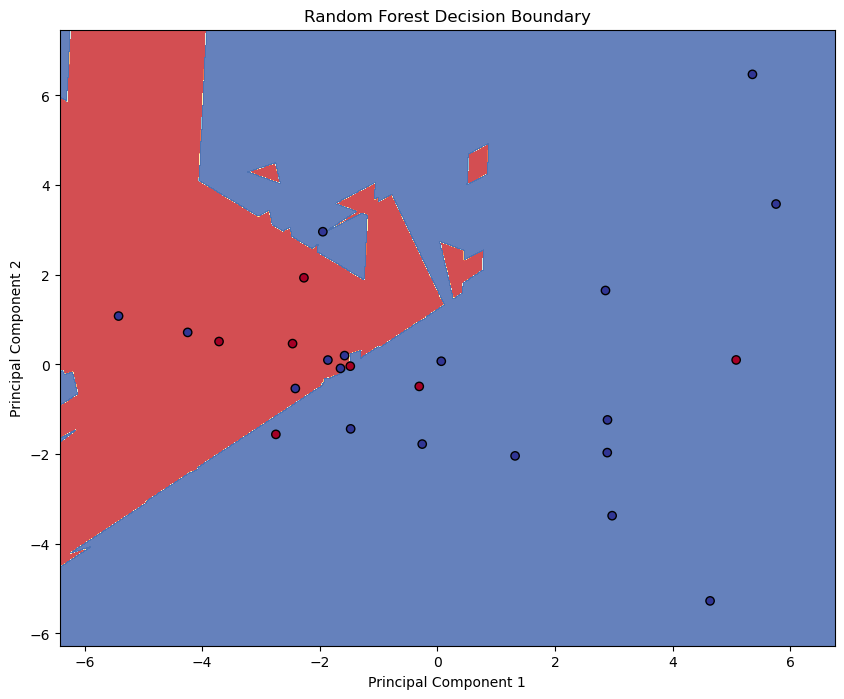

2025-01-09 16:03:45,526 - INFO - Decision boundary plot displayed successfully.
2025-01-09 16:03:45,533 - INFO - 📌 Tuning hyperparameters for Decision Tree...
2025-01-09 16:03:45,534 - INFO - Starting hyperparameter tuning for Decision Tree...
2025-01-09 16:03:45,537 - INFO - Parameter space: {'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None), 'splitter': Categorical(categories=('best', 'random'), prior=None)}
c:\Users\ghadf\anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 9, 2, 'random'] before, using random point ['entropy', 30, 4, 19, 'best']
  warnings.warn(
c:\Users\ghadf\anaconda3\envs\data_science_ml_prepr

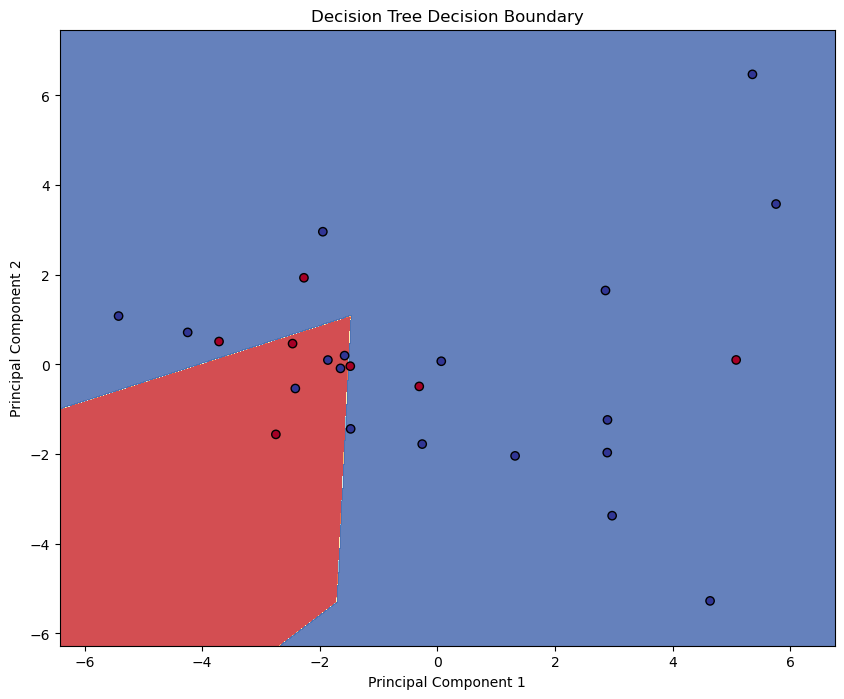

2025-01-09 16:04:28,924 - INFO - Decision boundary plot displayed successfully.
2025-01-09 16:04:28,931 - INFO - ✅ Best model is Decision Tree with Log Loss=0.8345673551170053
2025-01-09 16:04:28,933 - INFO - Model saved to C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\examples\preprocessor\models\Decision_Tree\trained_model.pkl
2025-01-09 16:04:28,934 - INFO - ✅ Model 'Decision Tree' saved successfully in 'C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\examples\preprocessor\models'.
2025-01-09 16:04:28,935 - INFO - ✅ Tuning results saved to C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\examples\preprocessor\models\tuning_results.json.
2025-01-09 16:04:28,935 [INFO] ✅ Training workflow completed successfully.
2025-01-09 16:04:28,935 - INFO - ✅ Training workflow completed successfully.


In [ ]:
import logging
import json
from typing import Any, Dict
from pathlib import Path
import yaml
import pandas as pd
import joblib  # Ensure joblib is imported

# Local imports - Adjust the import paths based on your project structure
# from datapreprocessor import DataPreprocessor
# from train_utils.train_utils import (
#     evaluate_model, save_model, load_model, plot_decision_boundary,
#     tune_random_forest, tune_xgboost, tune_decision_tree
# )
# from model_factory import get_model

logger = logging.getLogger(__name__)

def load_config(config_path: Path) -> Dict[str, Any]:
    """
    Load configuration from a YAML file.

    Args:
        config_path (Path): Path to the configuration file.

    Returns:
        Dict[str, Any]: Configuration dictionary.
    """
    try:
        with config_path.open('r') as f:
            config = yaml.safe_load(f)
        logger.info(f"✅ Configuration loaded from {config_path}.")
        return config
    except Exception as e:
        logger.error(f"❌ Failed to load configuration: {e}")
        raise

def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: Path,
    classification_save_path: Path,
    tuning_results_save: Path,
    selected_models: Any,
    use_pca: bool = False
):
    """
    A streamlined function that:
      1) Tunes and trains models using Bayesian optimization.
      2) Evaluates the best model.
      3) Saves the tuning results and best model.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Test features and labels.
        selection_metric (str): Metric to select best model (e.g., "Log Loss", "accuracy").
        model_save_dir (Path): Directory to save the best model.
        classification_save_path (Path): Path to save classification report.
        tuning_results_save (Path): Path to save tuning results in JSON format.
        selected_models (list|str): List of models (e.g. ["XGBoost", "Random Forest"]) or a single string.
        use_pca (bool): If True, uses PCA for boundary plotting. Typically False for tree-based models.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        # "XGBoost": tune_xgboost,
        "Random Forest": tune_random_forest,
        "Decision Tree": tune_decision_tree
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Ensure model_save_dir exists
    model_save_dir.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Ensured that the model save directory '{model_save_dir}' exists.")

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_key = selection_metric.lower().replace(" ", "_")
            metric_value = metrics.get(metric_key)

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model information
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            save_model(best_model, best_model_name, save_dir=model_save_dir)
            logger.info(f"✅ Model '{best_model_name}' saved successfully in '{model_save_dir}'.")
        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated

        # Add Best Model info to tuning_results
        tuning_results["Best Model"] = {
            "model_name": best_model_name,
            "metric_value": best_metric_value,
            "path": str(Path(model_save_dir) / best_model_name.replace(" ", "_") / 'trained_model.pkl')
        }
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with tuning_results_save.open("w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")


def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config = load_config(Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml'))

    # Extract paths from configuration
    paths_config = config.get('paths', {})
    base_data_dir = Path(paths_config.get('data_dir', '../../dataset/test/data')).resolve()
    raw_data_file = base_data_dir / paths_config.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = base_data_dir / paths_config.get('processed_data_dir', 'preprocessor/processed')
    features_metadata_file = base_data_dir / paths_config.get('features_metadata_file', 'features_info/features_metadata.pkl')
    predictions_output_dir = base_data_dir / paths_config.get('predictions_output_dir', 'preprocessor/predictions')
    config_file = Path(paths_config.get('config_file', 'preprocessor_config/preprocessor_config.yaml')).resolve()

    # Output directories
    log_dir = Path(paths_config.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_base_dir = Path(paths_config.get('model_save_base_dir', '../preprocessor/models')).resolve()
    transformers_save_base_dir = Path(paths_config.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()
    plots_output_dir = Path(paths_config.get('plots_output_dir', '../preprocessor/plots')).resolve()
    training_output_dir = Path(paths_config.get('training_output_dir', '../preprocessor/training_output')).resolve()

    # Initialize Paths for saving
    MODEL_SAVE_DIR = model_save_base_dir
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    CLASSIFICATION_REPORT_PATH = MODEL_SAVE_DIR / "classification_report.txt"
    TUNING_RESULTS_SAVE_PATH = MODEL_SAVE_DIR / "tuning_results.json"


    LOG_FILE = 'training.log'

    SELECTED_MODELS = ["Random Forest"]  # For testing, select a single model
    SELECTION_METRIC = "accuracy"  # Change to "Log Loss" if needed

    # Extract model-related config
    selected_models = config.get('models', {}).get('selected_models', ["XGBoost", "Random Forest", "Decision Tree"])
    selection_metric = config.get('models', {}).get('selection_metric', "Log Loss")

    # Extract Tree Based Classifier options from config
    tree_classifier_options = config.get('models', {}).get('Tree Based Classifier', {})

    # ----------------------------
    # 2. Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, LOG_FILE)
    logger.info("✅ Starting the training module.")

    # ----------------------------
    # 3. Load Data
    # ----------------------------
    try:
        filtered_df = pd.read_csv(raw_data_file)
        logger.info(f"✅ Loaded dataset from {raw_data_file}. Shape: {filtered_df.shape}")
    except FileNotFoundError:
        logger.error(f"❌ Dataset not found at {raw_data_file}.")
        return
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        return

    # Extract feature assets
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # 4. Initialize DataPreprocessor
    # ----------------------------
    # Assuming a supervised classification use case: "Tree Based Classifier"
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []), 
        mode='train',
        options=tree_classifier_options,  # The options from config for "Tree Based Classifier"
        debug=config.get('logging', {}).get('debug', False),  # or config-based
        normalize_debug=config.get('execution', {}).get('train', {}).get('normalize_debug', False),
        normalize_graphs_output=config.get('execution', {}).get('train', {}).get('normalize_graphs_output', False),
        graphs_output_dir=plots_output_dir,
        transformers_dir=transformers_save_base_dir
    )

    # ----------------------------
    # 5. Execute Preprocessing
    # ----------------------------
    try:
        # Execute preprocessing by passing the entire filtered_df
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        print("types of all variables starting with X_train", type(X_train), "X_test type", type(X_test), "y_train type =", type(y_train), "y_test type =", type(y_test),"X_test_inverse type =", type(X_test_inverse))
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return

    # ----------------------------
    # 6. Train & Tune the Model
    # ----------------------------
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=MODEL_SAVE_DIR,
            classification_save_path=CLASSIFICATION_REPORT_PATH,
            tuning_results_save=TUNING_RESULTS_SAVE_PATH,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    # ----------------------------
    # 7. Completion Message
    # ----------------------------
    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()

In [47]:
# src/ml/predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
import json
from pathlib import Path
from typing import Any, Dict

# Local imports - Adjust based on your project structure
# from train_utils.train_utils import load_model  # Ensure correct import path
# from datapreprocessor.datapreprocessor import DataPreprocessor  # Uncomment and adjust as necessary

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> Dict[str, Any]:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'prediction.log') -> logging.Logger:
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename

    logger = logging.getLogger('model_prediction')
    logger.setLevel(logging.INFO)

    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()

    # Create handlers
    f_handler = logging.FileHandler(log_path)
    f_handler.setLevel(logging.INFO)
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)

    # Create formatters and add them to handlers
    formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)

    return logger

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml')  # Adjust as needed
    try:
        config = load_config(config_path)
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    paths = config.get('paths', {})
    data_dir = Path(paths.get('base_data_dir', '../../dataset/test/data')).resolve()
    raw_data_path = data_dir / paths.get('raw_data_file', 'final_ml_dataset.csv')  # Corrected key
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'preprocessor/processed')
    transformers_dir = Path(paths.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()  # Corrected key
    predictions_output_dir = Path(paths.get('predictions_output_dir', 'preprocessor/predictions')).resolve()
    log_dir = Path(paths.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_dir = Path(paths.get('model_save_base_dir', '../preprocessor/models')).resolve()  # Corrected key
    log_file = paths.get('log_file', 'prediction.log')  # Ensure this key exists in config

    # ----------------------------
    # Step 3: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info("✅ Starting prediction module.")

    # ----------------------------
    # Step 4: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # Step 5: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 6: Preprocess the Data
    # ----------------------------
    # Load Prediction Dataset
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = load_dataset(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Or dynamically set based on best_model_name if necessary
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},  # Adjust based on config or load from somewhere
        debug=False,  # Can be parameterized
        normalize_debug=False,  # As per hardcoded paths
        normalize_graphs_output=False,  # As per hardcoded paths
        graphs_output_dir=Path(paths.get('plots_output_dir', '../preprocessor/plots')).resolve(),
        transformers_dir=transformers_dir
    )

    # Execute Preprocessing for Prediction
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type = ", type(X_preprocessed), "X_new_inverse type = ", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        logger.info(f"✅ Trained model loaded from '{model_save_dir / best_model_name.replace(' ', '_') / 'trained_model.pkl'}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions
    # ----------------------------
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    # ----------------------------
    # Step 9: Attach Predictions to Inversed Data
    # ----------------------------
    if X_inversed is not None:
        if len(predictions) == len(X_inversed):
            X_inversed['predictions'] = predictions
            logger.info("✅ Predictions attached to inversed data successfully.")
        else:
            logger.error("❌ Predictions length does not match inversed data length.")
            return
    else:
        logger.error("❌ Inversed data is None. Cannot attach predictions.")
        return

    # ----------------------------
    # Step 10: Save Predictions
    # ----------------------------
    try:
        predictions_output_dir.mkdir(parents=True, exist_ok=True)
        predictions_filename = predictions_output_dir / f'predictions_{best_model_name.replace(" ", "_")}.csv'
        X_inversed.to_csv(predictions_filename, index=False)
        logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    logger.info(f"✅ All prediction tasks completed successfully for model '{best_model_name}'.")


if __name__ == "__main__":
    main()

2025-01-09 16:04:28,983 [INFO] ✅ Starting prediction module.
2025-01-09 16:04:28,983 - INFO - ✅ Starting prediction module.
2025-01-09 16:04:28,992 [INFO] Best model identified: Decision Tree
2025-01-09 16:04:28,992 - INFO - Best model identified: Decision Tree
2025-01-09 16:04:28,998 [INFO] ✅ Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv'.
2025-01-09 16:04:28,998 - INFO - ✅ Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv'.
2025-01-09 16:04:29,000 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-01-09 16:04:29,000 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-01-09 16:04:29,001 [INFO] Step: filter_columns
2025-01-09 16:04:29,001 - INFO - Step: filter_columns
2025-01-09 16:04:29,002 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2

X_new_preprocessed type =  <class 'pandas.core.frame.DataFrame'> X_new_inverse type =  <class 'pandas.core.frame.DataFrame'>
